In [1]:
%env DDE_BACKEND=tensorflow
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

env: DDE_BACKEND=tensorflow


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Parallelization
dde.config.set_parallel_scaling('weak') # Nao paralelo
# dde.config.set_parallel_scaling('strong') # Ativa paralelização

In [3]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2
v_i = 0

# n_domain = 2500
# n_boundary = 500
n_domain = 1250
n_boundary = 250
loss_weight = 1
simulation_name = "Caso_0"

import pathlib
pathlib.Path(f"./{simulation_name}").mkdir(exist_ok=True)

Re = rho * u_in * D / mu
Re

1.0

In [4]:
geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])

In [5]:
def upper_wall(X, on_boundary):
  on_upper_wall = np.logical_and(np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)), on_boundary)
  return on_upper_wall

def lower_wall(X, on_boundary):
  on_lower_wall = np.logical_and(np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)),on_boundary)
  return on_lower_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

In [6]:
def zero(x):
    return 0.

def inlet_u(x):
    return u_in

def wall_u(x):
    return v_i

bc_wall_u_up = dde.DirichletBC(geom, wall_u, upper_wall, component =0)
bc_wall_u_down = dde.DirichletBC(geom, zero, lower_wall, component =0)
bc_wall_v_up = dde.DirichletBC(geom, zero, upper_wall, component =1)
bc_wall_v_down = dde.DirichletBC(geom, zero, lower_wall, component =1)

bc_inlet_u = dde.DirichletBC(geom, inlet_u, boundary_inlet, component =0)
bc_inlet_v = dde.DirichletBC(geom, zero, boundary_inlet, component =1)

bc_outlet_p = dde.DirichletBC(geom, zero, boundary_outlet, component =2)
bc_outlet_v = dde.DirichletBC(geom, zero, boundary_outlet, component =1)

In [7]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)

    # Definições para newtoniano para componentes do tensor de tensão
    tau_xy =  mu * (du_y + dv_x)
    tau_xx =  2 * mu * du_x
    tau_yx =  mu * (dv_x + du_y)
    tau_yy =  2 * mu * dv_y

    # Derivadas dos tensores de tensão
    dtau_xx_x = dde.grad.jacobian(tau_xx, X, i=0, j=0)
    dtau_xy_x = dde.grad.jacobian(tau_xy, X, i=0, j=0)
    dtau_yx_y = dde.grad.jacobian(tau_yx, X, i=0, j=1)
    dtau_yy_y = dde.grad.jacobian(tau_yy, X, i=0, j=1)

    # Termos de advecção para as componentes u e v
    advec_u = Y[:,0:1] * du_x + Y[:,1:2] * du_y
    advec_v = Y[:,0:1] * dv_x + Y[:,1:2] * dv_y
    
    # Tensões na particula fluida
    tensao_x =  dp_x -  dtau_yx_y - dtau_xx_x
    tensao_y =  dp_y -  dtau_xy_x - dtau_yy_y

    # Equações de Navier-Stokes modificadas para incluir todos os tensores de tensão
    pde_u = rho * advec_u + tensao_x
    pde_v = rho * advec_v + tensao_y
    
    # Equação de continuidade
    pde_cont = du_x + dv_y  

    return [pde_u, pde_v, loss_weight * pde_cont]

In [8]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u_up,bc_wall_u_down,bc_wall_v_up,bc_wall_v_down,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                    num_domain = n_domain,
                    num_boundary = n_boundary,
                    num_test = 2000)

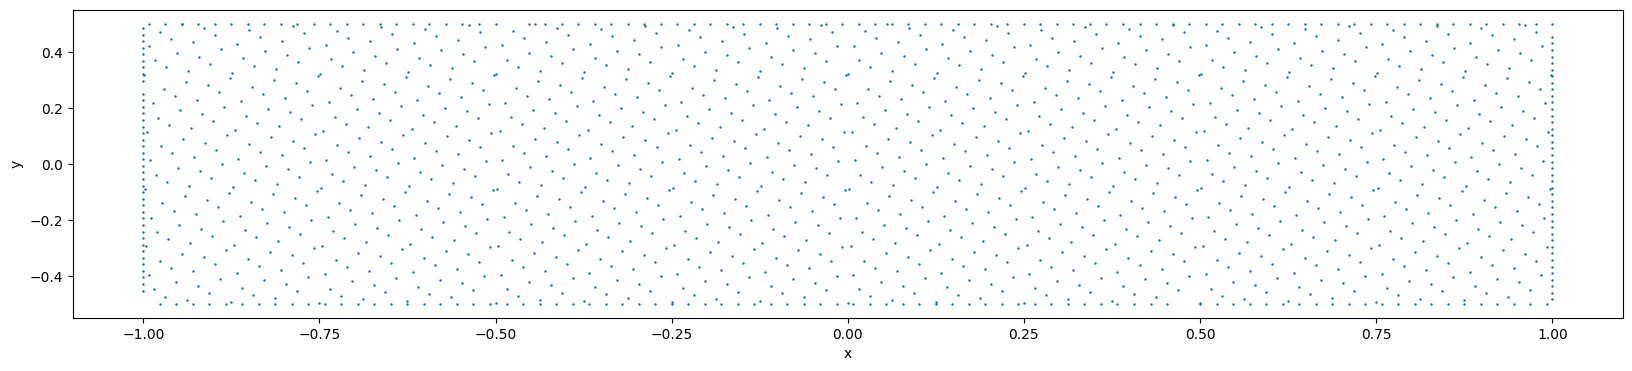

,pos_x,pos_y
0,1.000000,0.500000
1,0.500000,-0.500000
2,-0.500000,0.500000
3,-0.250000,-0.500000
4,0.250000,0.500000
...,...,...
1495,-0.038086,0.496003
1496,0.961914,0.496803
1497,-0.944336,0.497602
1498,0.055664,0.498401


In [24]:
import pandas as pd

# Exportar training points

# position_df = pd.DataFrame({"pos_x" : data.train_x_all[:,0], "pos_y" : data.train_x_all[:,1]})
# position_df.to_csv(f"./{simulation_name}/train_points.csv", index=False)

# position_df

# Carregar training points

# position_df = pd.read_csv(f"./{simulation_name}/train_points.csv")
# data.train_x_all[:,0] = position_df["pos_x"].to_numpy()
# data.train_x_all[:,1] = position_df["pos_y"].to_numpy()

plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(f"./{simulation_name}/training_points.png")
plt.show()
plt.close()

position_df

In [ ]:
net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")

In [ ]:
model = dde.Model(data, net)
# model.compile("adam", lr=1e-3, loss_weights=[1,1,loss_weight,1,1,1,1,1,1,1,1])
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.001086 s



In [ ]:
# losshistory,train_state = model.train(iterations = 10000, display_every=100)
losshistory,train_state = model.train(iterations = 4000, display_every=100)
# model.restore("./out/placa_plana-15911.ckpt.index")

Training model...



c:\Users\Pablo\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-4PBOT-FI-py3.10\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [2.22e-01, 1.34e-02, 2.95e-01, 6.32e-02, 6.15e-02, 1.01e-02, 1.02e-02, 1.94e+00, 1.51e-02, 2.06e-02, 1.50e-02]    [2.14e-01, 1.23e-02, 3.03e-01, 6.32e-02, 6.15e-02, 1.01e-02, 1.02e-02, 1.94e+00, 1.51e-02, 2.06e-02, 1.50e-02]    []  
100       [2.18e-04, 2.53e-04, 2.43e-02, 9.00e-02, 8.68e-02, 1.32e-02, 1.27e-02, 1.68e-01, 3.63e-03, 9.75e-06, 3.76e-03]    [1.77e-04, 1.88e-04, 2.46e-02, 9.00e-02, 8.68e-02, 1.32e-02, 1.27e-02, 1.68e-01, 3.63e-03, 9.75e-06, 3.76e-03]    []  
200       [8.87e-03, 4.17e-04, 2.82e-02, 7.64e-02, 7.05e-02, 1.31e-02, 1.48e-02, 1.36e-01, 4.18e-03, 1.80e-05, 3.31e-03]    [6.71e-03, 3.27e-04, 2.78e-02, 7.64e-02, 7.05e-02, 1.31e-02, 1.48e-02, 1.36e-01, 4.18e-03, 1.80e-05, 3.31e-03]    []  
300       [1.34e-02, 

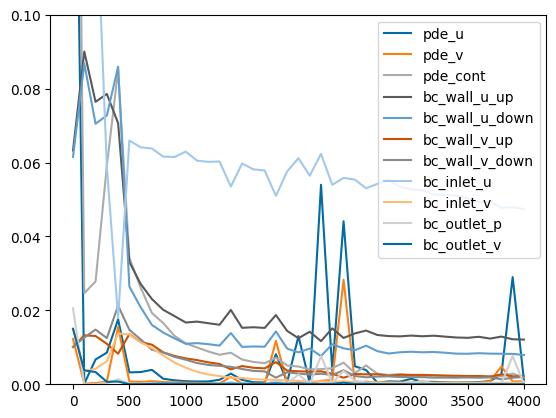

In [ ]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u_up", "bc_wall_u_down", "bc_wall_v_up", "bc_wall_v_down", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.savefig(f"./{simulation_name}/residual_adam.png")
plt.show()
plt.close()

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter = 2500)
model.compile("L-BFGS")
losshistory,train_state = model.train(iterations=3000, display_every=100)
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

# model.save(f"./{simulation_name}/model_adam", protocol="backend")

Compiling model...
'compile' took 1.487550 s

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
4000      [1.32e-03, 8.54e-04, 3.93e-03, 1.21e-02, 7.94e-03, 2.09e-03, 1.98e-03, 4.74e-02, 4.85e-04, 8.04e-05, 1.74e-05]    [1.03e-03, 7.89e-04, 1.88e-03, 1.21e-02, 7.94e-03, 2.09e-03, 1.98e-03, 4.74e-02, 4.85e-04, 8.04e-05, 1.74e-05]    []  
6500      [8.32e-04, 4.69e-04, 2.27e-03, 4.14e-03, 1.42e-03, 9.42e-04, 7.17e-04, 7.83e-03, 1.81e-03, 2.91e-05, 3.56e-06]    [7.19e-04, 3.47e-04, 1.46e-03, 4.14e-03, 1.42e-03, 9.42e-04, 7.17e-04, 7.83e-03, 1.81e-03, 2.91e-05, 3.56e-06]    []  

Best model at step 6500:
  train loss: 2.05e-02
  test loss: 1.94e-02
  test metric: []

'train' took 3598.457550 s



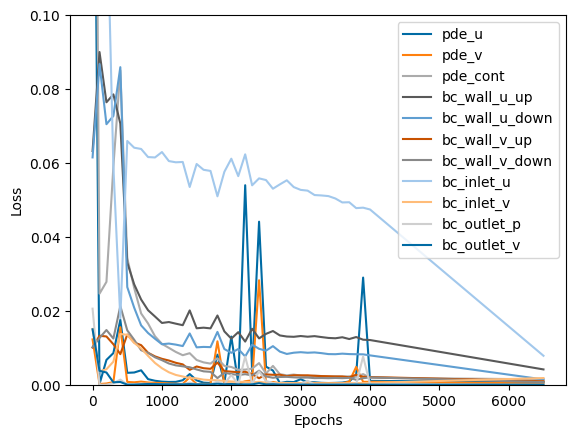

In [ ]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u_up", "bc_wall_u_down", "bc_wall_v_up", "bc_wall_v_down", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 0.1])
plt.savefig(f"./{simulation_name}/residual_L-BFGS.png")
plt.show()
plt.close()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_20416\2744020867.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


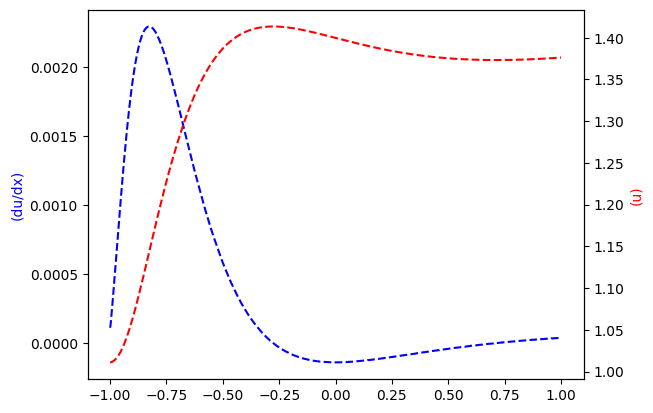

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_points = 1000
x2 = np.linspace(-L/2, L/2, n_points)
samples = np.zeros((n_points, 2))
samples[:, 0] = x2

result = model.predict(samples)

fig, ax = plt.subplots()
# ax.plot(samples[:, 1], u_exact, label="Analytic")
# ax.plot(x2, result[:, 2], label="PINN (p)", linestyle="dashed", color="blue")
ax.plot(x2, np.gradient(result[:, 0]), label="PINN (du/dx)", linestyle="dashed", color="blue")
ax.set_ylabel('(du/dx)', color="blue") 

ax2 = ax.twinx()
ax2.plot(x2, result[:, 0], label="PINN (u)", linestyle="dashed", color="red")
ax2.set_ylabel('(u)', color="red") 
# ax.legend()
# ax2.legend()
fig.savefig(f"./{simulation_name}/u_profiles.png")
fig.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_20416\25719457.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


2.0 5
delta_p/L analytic 12.0
delta_p/L PINN [10.865194]


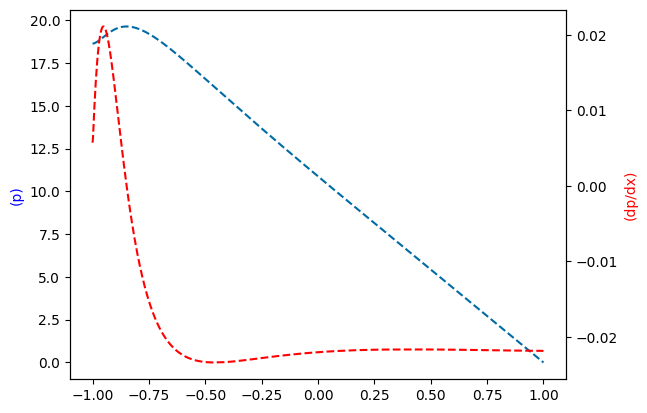

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_points = 1000
x2 = np.linspace(-L/2, L/2, n_points)
samples = np.zeros((n_points, 2))
samples[:, 0] = x2

result = model.predict(samples)

fig, ax = plt.subplots()
# ax.plot(samples[:, 1], u_exact, label="Analytic")
ax.plot(x2, result[:, 2], label="PINN (p)", linestyle="dashed")
ax.set_ylabel('(p)', color="blue") 

ax2 = ax.twinx()
ax2.plot(x2, np.gradient(result[:, 2]), label="PINN (dp/dx)", linestyle="dashed", color="red")
ax2.set_ylabel('(dp/dx)', color="red") 
# ax.legend()
# ax2.legend()
fig.savefig(f"./{simulation_name}/p_profiles.png")
fig.show()

Dh = 2 * D
Re = rho * u_in * Dh / mu
# Le = 0.05 * Re * Dh
Le = 5 * D
print(Re, Le)

Delta_p_L_analytic = 12 * u_in * mu / (D ** 3)
result = model.predict(np.array([[L/2 - 0.1, 0]]))

print("delta_p/L analytic", Delta_p_L_analytic)
print("delta_p/L PINN", result[:, 2] / 0.1)

pd.DataFrame({"Delta_p_analytic" : Delta_p_L_analytic, "Delta_p_PINN" : result[:, 2] / 0.1}).to_csv(f"./{simulation_name}/delta_p.csv")

In [ ]:
import numpy as np
import pandas as pd

n_points = 1000
x2 = np.linspace(-D/2, D/2, n_points)
samples = np.zeros((n_points, 2))
samples[:, 1] = x2

result = model.predict(samples)

probe_points = np.array([[L/2 - 0.01, 0], [L/2 - 0.5, 0]])
probe_pressao = model.predict(probe_points)

delta_p = probe_pressao[0,2] - probe_pressao[1,2]
length = probe_points[0, 0] - probe_points[1, 0]

def u_analytic(x):
    position = x[:, 1] - x[:, 1].min()
    return np.array(1 / mu * (position ** 2 / 2 * delta_p / length + (mu * v_i / D - D / 2 * delta_p / length) * position), dtype=np.float32)

u_exact = u_analytic(samples).reshape(-1)

f = model.predict(samples, operator=pde)
l2_diff_u = dde.metrics.l2_relative_error(u_exact, result[:, 0])
residual = np.mean(np.absolute(f))

result_df = pd.DataFrame({"residual": [residual], "l2_diff_u": [l2_diff_u]})
result_df.to_csv(f"./{simulation_name}/result.csv")

In [ ]:
# Export dos resultados de validação
import numpy as np
import pandas as pd

probe_lines = {
    "center_horizontal_line" : np.array([[(i - 500) * L / 1000, 0] for i in range(1001)], dtype=np.float32),
    "center_vertical_line" : np.array([[0, (i - 500) * D / 1000] for i in range(1001)], dtype=np.float32),
    "inlet_probe" : np.array([[-L/2 + 0.01, (i - 500) * D / 1000] for i in range(1001)], dtype=np.float32),
    "outlet_probe" : np.array([[L/2 - 0.01, (i - 500) * D / 1000] for i in range(1001)], dtype=np.float32),
}

target_probe_step = 0.1

for i in range(int((L/2 - 0.01) / target_probe_step)):
    probe_lines |= {f"probe_at_x_{-L/2 + 0.01 + (i + 1) * target_probe_step:.2f}" : np.array([[-L/2 + 0.01 + (i + 1) * target_probe_step, (i - 500) * D / 1000] for i in range(1001)], dtype=np.float32)}

for probe_name, probe_points in probe_lines.items():
    probe_result = model.predict(probe_points)
    probe_df = pd.DataFrame({"Points_x" : probe_points[:,0], "Points_y" : probe_points[:,1], "u" : probe_result[:, 0], "v" : probe_result[:, 1], "p" : probe_result[:, 2]})
    probe_df.to_csv(f"./{simulation_name}/{probe_name}.csv")

C:\Users\Pablo\AppData\Local\Temp\ipykernel_20416\3090138244.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


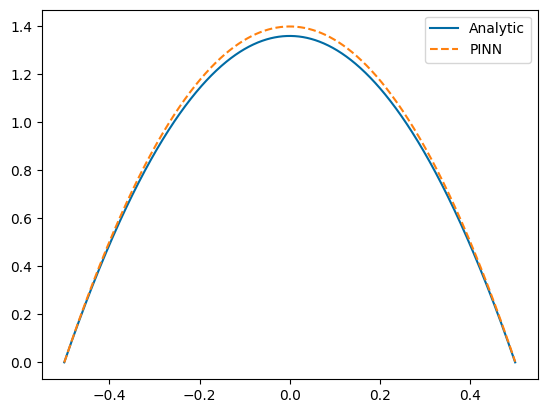

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(samples[:, 1], u_exact, label="Analytic")
ax.plot(samples[:, 1], result[:, 0], label="PINN", linestyle="dashed")
ax.legend()
fig.savefig(f"./{simulation_name}/u_profile_comparison.png")
fig.show()

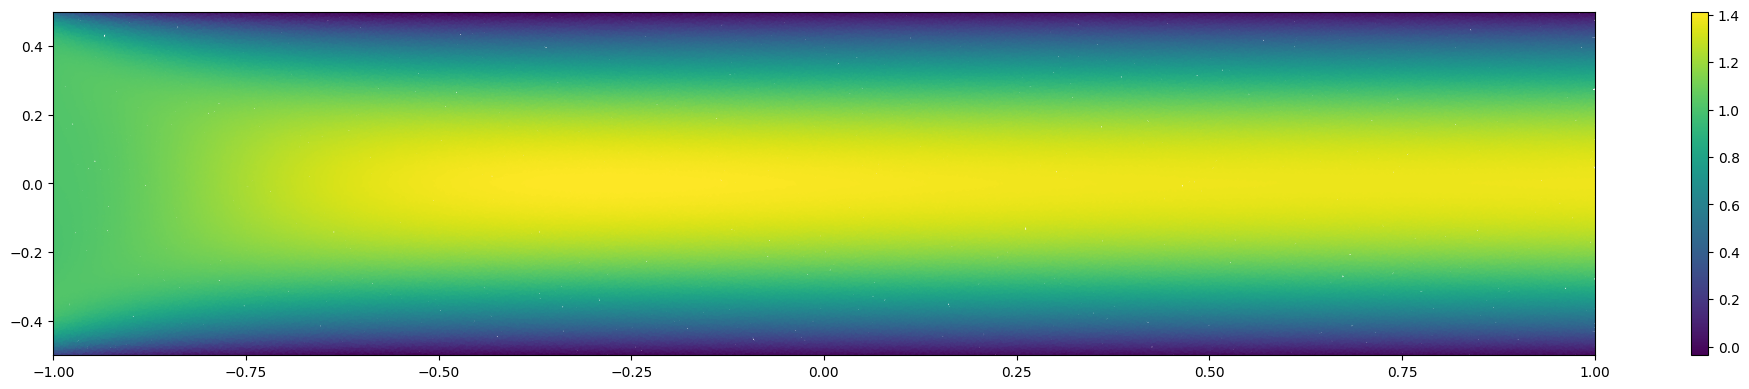

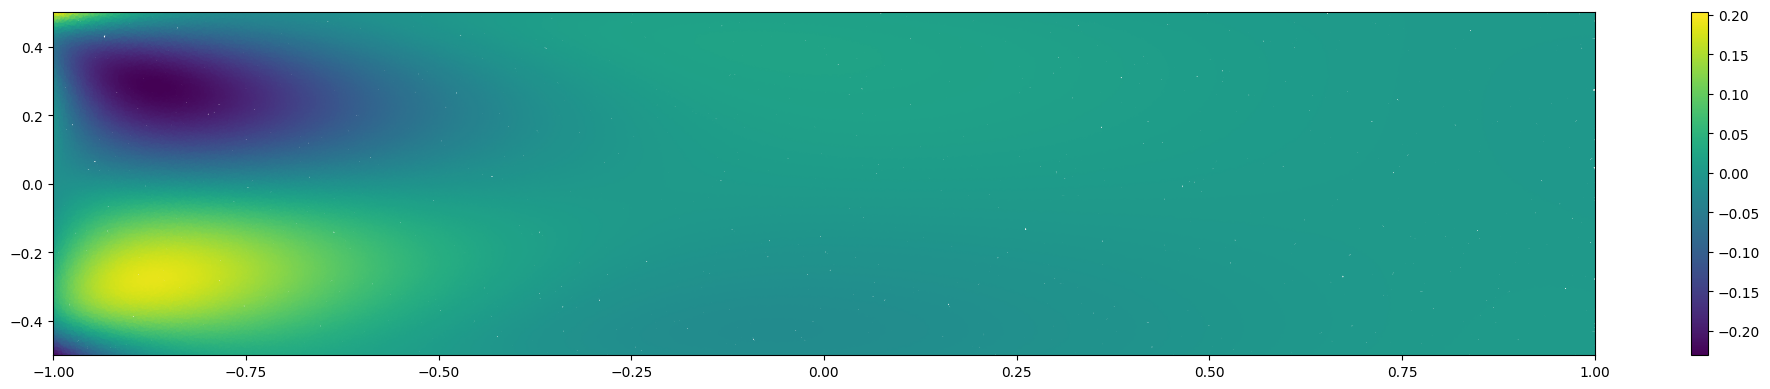

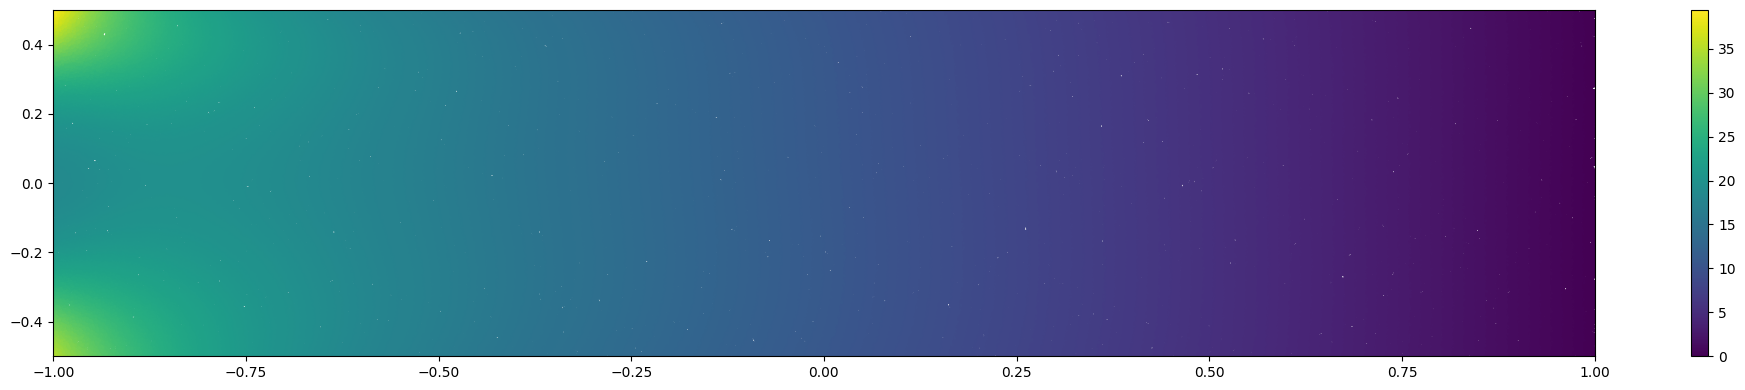

In [ ]:
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

samples= geom.random_points(500000)
result = model.predict(samples)

for idx, field in enumerate(["u", "v", "p"]):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               s=2)
    plt.colorbar()
    plt.clim([result[:,idx].min(), result[:,idx].max()])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.savefig(f"./{simulation_name}/{field}_colormap.png")
    plt.show()
    plt.close()